In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, mean_squared_error as mse

tf.keras.backend.set_floatx('float32')

# Preprocessing

In [13]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = np.where(x_train > 127.5, 1.0, 0.0).astype('float32')
x_test = np.where(x_test > 127.5, 1.0, 0.0).astype('float32')
x_train = np.reshape(x_train, (len(x_train), -1))
x_test = np.reshape(x_test, (len(x_test), -1))

# Encoder

In [14]:
input_dim = 784  # 28x28
latent_dim = 2  # 潜在空間の次元

inputs = Input(shape=(input_dim,))
h_q = Dense(512, activation='relu')(inputs)
h_q = Dense(512, activation='relu')(h_q)
z_mean = Dense(latent_dim)(h_q)
z_log_var = Dense(latent_dim)(h_q)

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense_20 (Dense)            (None, 512)                  401920    ['input_7[0][0]']             
                                                                                                  
 dense_21 (Dense)            (None, 512)                  262656    ['dense_20[0][0]']            
                                                                                                  
 dense_22 (Dense)            (None, 2)                    1026      ['dense_21[0][0]']            
                                                                                            

# Definition and Training of VAE Model and Loss Function

In [15]:
latent_inputs = Input(shape=(latent_dim,))
h_p = Dense(512, activation='relu')(latent_inputs)
h_p = Dense(512, activation='relu')(h_p)
outputs = Dense(input_dim, activation='sigmoid')(h_p)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

reconstruction_loss = binary_crossentropy(inputs, outputs) * input_dim
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()


history_vae = vae.fit(x_train, epochs=50, batch_size=128, validation_data=(x_test, None))


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_24 (Dense)            (None, 512)               1536      
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 dense_26 (Dense)            (None, 784)               402192    
                                                                 
Total params: 666384 (2.54 MB)
Trainable params: 666384 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape  

# Definition of the EMDecoder Class

In [16]:
class EMDecoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim, input_dim, n_components=10, n_iterations=10):
        super(EMDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.n_components = n_components
        self.n_iterations = n_iterations
        self.means = tf.Variable(tf.random.normal([n_components, latent_dim]), trainable=False)
        self.log_vars = tf.Variable(tf.zeros([n_components, latent_dim]), trainable=False)
        self.pis = tf.Variable(tf.ones([n_components]) / n_components, trainable=False)
        
        self.dense1 = Dense(512, activation='relu')
        self.dense2 = Dense(512, activation='relu')
        self.output_layer = Dense(input_dim, activation='sigmoid')
    
    def e_step(self, z):
        gamma = tf.exp(tf.reduce_sum(-0.5 * (tf.expand_dims(z, 1) - self.means) ** 2 / tf.exp(self.log_vars), axis=-1))
        gamma /= tf.reduce_sum(gamma, axis=-1, keepdims=True)
        return gamma
    
    def m_step(self, z, gamma):
        Nk = tf.reduce_sum(gamma, axis=0)
        self.means.assign(tf.reduce_sum(tf.expand_dims(gamma, -1) * tf.expand_dims(z, 1), axis=0) / tf.expand_dims(Nk, -1))
        self.log_vars.assign(tf.math.log(tf.reduce_sum(tf.expand_dims(gamma, -1) * (tf.expand_dims(z, 1) - self.means) ** 2, axis=0) / tf.expand_dims(Nk, -1)))
        self.pis.assign(Nk / tf.reduce_sum(Nk))
    
    def call(self, z):
        for _ in range(self.n_iterations):
            gamma = self.e_step(z)
            self.m_step(z, gamma)
        h = self.dense1(z)
        h = self.dense2(h)
        reconstruction = self.output_layer(h)
        return reconstruction

latent_inputs = Input(shape=(latent_dim,))
em_decoder = EMDecoder(latent_dim, input_dim, n_iterations=10)  # ここで反復回数を設定
outputs = em_decoder(latent_inputs)
em_decoder_model = Model(latent_inputs, outputs, name='em_decoder')
em_decoder_model.summary()

# EM VAEモデルの定義
outputs = em_decoder_model(encoder(inputs)[2])
em_vae = Model(inputs, outputs, name='em_vae')

# 損失関数の定義
reconstruction_loss = binary_crossentropy(inputs, outputs) * input_dim
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)
em_vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
em_vae.add_loss(em_vae_loss)
em_vae.compile(optimizer='adam')
em_vae.summary()

# EM VAEのトレーニング
history_em_vae = em_vae.fit(x_train, epochs=50, batch_size=128, validation_data=(x_test, None))


Model: "em_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 2)]               0         
                                                                 
 em_decoder_3 (EMDecoder)    (None, 784)               666434    
                                                                 
Total params: 666434 (2.54 MB)
Trainable params: 666384 (2.54 MB)
Non-trainable params: 50 (200.00 Byte)
_________________________________________________________________
Model: "em_vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 

1/1 [==============================] - 0s 71ms/step


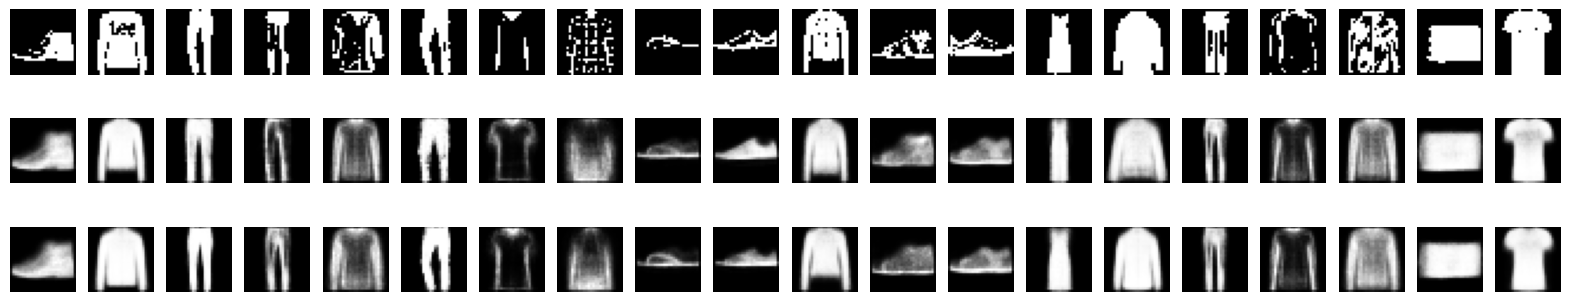

In [23]:
def plot_reconstructed(x_test, vae_model, em_vae_model):
    n = 20
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        ax.axis('off')

        vae_recon = vae_model.predict(x_test[i:i+1])
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(vae_recon.reshape(28, 28), cmap='gray')
        ax.axis('off')

        em_vae_recon = em_vae_model.predict(x_test[i:i+1])
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(em_vae_recon.reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

plot_reconstructed(x_test, vae, em_vae)




In [18]:
#
x_decoded = vae.predict(x_test)
x_em_decoded = em_vae.predict(x_test)

mse_vae = mse(x_test, x_decoded)
psnr_vae = np.mean([psnr(x_test[i], x_decoded[i]) for i in range(len(x_test))])


mse_em_vae = mse(x_test, x_em_decoded)
psnr_em_vae = np.mean([psnr(x_test[i], x_em_decoded[i]) for i in range(len(x_test))])

print(f'VAE MSE: {mse_vae:.4f}')
print(f'VAE PSNR: {psnr_vae:.4f}')

print(f'EM VAE MSE: {mse_em_vae:.4f}')
print(f'EM VAE PSNR: {psnr_em_vae:.4f}')


313/313 [==============================] - 3s 9ms/step
VAE MSE: 0.0783
VAE PSNR: 11.6534
EM VAE MSE: 0.0636
EM VAE PSNR: 12.7280
